# Optimized Multi-Agent Student Assessment

This version implements:
1. **Pydantic Structured Outputs**: Zero conversational filler, only raw data.
2. **Instruction Distillation**: High-density prompts to save tokens.
3. **Context Trimming**: Agents only process relevant state keys.

In [55]:
import os
from dotenv import load_dotenv

load_dotenv('../../.env') 
print(f"API Keys loaded. OpenAI: {'found' if os.getenv('OPENAI_API_KEY') else 'not found'}")

API Keys loaded. OpenAI: found


In [ ]:
from typing import List, Optional, Dict, Any
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Markdown, Image


## 1. Structured Output Schemas
Defining exact models to force the LLM to skip descriptive text and return structured data.

In [74]:
class AlgoAnalysis(BaseModel):
    algorithm: str = Field(description="Algorithm used (e.g. Recursion, DP)")
    time_complexity: str = Field(description="O(N) notation")
    space_complexity: str = Field(description="O(N) notation")
    score: int = Field(description="optimality score 0-20")

class OwnershipQuestions(BaseModel):
    questions: List[str] = Field(description="3 hard questions about specific logic invariants")

class AdaptabilityResult(BaseModel):
    break_scenario: str = Field(description="Specific constraint change that breaks the code")
    required_fix: str = Field(description="How to fix it (short)")
    
# class OriginalityResult(BaseModel):
#     score: int = Field(description="0-15 (15=Human, 0=AI/Copy)")
#     flags: List[str] = Field(description="List of suspicious patterns")
class OriginalityResult(BaseModel):
    score: int = Field(description="0-15 (15=Human, 0=AI/Copy)")
    explanation: str = Field(description="Brief justification for the score") # <--- Add this
    flags: List[str] = Field(description="List of suspicious patterns")
    
class ProcessResult(BaseModel):
    score: int = Field(description="0-20 score for iteration quality")
    iteration_detected: bool = Field(description="Did they edit/fix code?")

In [58]:
class AgentState(TypedDict):
    # Inputs
    problem_statement: str
    student_code: str
    execution_logs: str
    
    # Agent Outputs (Now typed as Dicts/Objects)
    agent1_algo: Optional[Dict]
    agent2_ownership: Optional[List[str]]
    agent3_adaptability: Optional[Dict]
    agent4_originality: Optional[Dict]
    agent5_process: Optional[Dict]
    
    final_report: Optional[str]

In [59]:
# GPT-4o-mini is high-reasoning/low-cost. 
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## 2. Optimized Agent Nodes

In [75]:
# Agent 1: Algorithmic Analyzer
def agent_algorithm(state: AgentState):
    print("[1] Algo Analysis...")
    structured_llm = llm.with_structured_output(AlgoAnalysis)
    # DISTILLATION: Use shorthand prompt
    prompt = f"Analyze code complexity for problem: {state['problem_statement']}\nCode: {state['student_code']}"
    res = structured_llm.invoke(prompt)
    return {"agent1_algo": res.model_dump()}

# Agent 2: Concepts/Ownership
def agent_ownership(state: AgentState):
    print("[2] Ownership Probing...")
    structured_llm = llm.with_structured_output(OwnershipQuestions)
    prompt = f"""Target the most unusual/complex parts of this code. 
            If code is obfuscated or uses advanced patterns (like lambdas/closures) for simple tasks, 
            ask 'Why' questions that require deep conceptual justification.
            Code: {state['student_code']}"""
            
    res = structured_llm.invoke(prompt)
    return {"agent2_ownership": res.questions}

# Agent 3: Constraint Adaptability
def agent_adaptability(state: AgentState):
    print("[3] Adaptability Analysis...")
    structured_llm = llm.with_structured_output(AdaptabilityResult)
    prompt = f"ID a constraint change that breaks this code and suggest a fix. Problem: {state['problem_statement']}\nCode: {state['student_code']}"
    res = structured_llm.invoke(prompt)
    return {"agent3_adaptability": res.model_dump()}

# Agent 4: Originality/AI Detection
def agent_originality(state: AgentState):
    print("[4] Checking Originality...")
    structured_llm = llm.with_structured_output(OriginalityResult)
    prompt = f"""Act as a Tier-1 code forensics expert. 
            Look for: 
            1. Over-engineering (e.g. using a Y-combinator for a simple loop).
            2. Academic patterns rarely used by students.
            3. Perfect PEP8 styling in otherwise obscure code.
            Score 0-15 (0 = Certain AI/Copy, 15 = Genuine Human).
            Code: {state['student_code']}"""
            
    res = structured_llm.invoke(prompt)
    return {"agent4_originality": res.model_dump()}

# Agent 5: Process Trace
def agent_process(state: AgentState):
    print("[5] Analyzing Session Logs...")
    structured_llm = llm.with_structured_output(ProcessResult)
    prompt = f"Analyze logs for iteration/refinement vs copy-paste.\nLogs: {state['execution_logs']}"
    res = structured_llm.invoke(prompt)
    return {"agent5_process": res.model_dump()}

# Supervisor: Aggregation
def supervisor_node(state: AgentState):
    print("[S] Aggregating Structured Results...")
    
    # Calculate raw score from structured data
    s1 = state['agent1_algo']['score']
    s4 = state['agent4_originality']['score']
    s5 = state['agent5_process']['score']
    total = s1 + s4 + s5 # Max 50 for these 3
    
    report = f"""
    ### ASSESSMENT SCORE: {total}/50
    - **Complexity**: {state['agent1_algo']['time_complexity']}
    - **Originality Verdict**: {state['agent4_originality']['score']}/15
    - **Reasoning**: {state['agent4_originality']['explanation']}
    - **Break Scenario**: {state['agent3_adaptability']['break_scenario']}
    
    **Verification Questions for Student:**
    1. {state['agent2_ownership'][0]}
    2. {state['agent2_ownership'][1]}
    3. {state['agent2_ownership'][2]}
    """
    return {"final_report": report}

## 3. Build Parallel Graph

In [76]:
workflow = StateGraph(AgentState)
workflow.add_node("agent_algorithm", agent_algorithm)
workflow.add_node("agent_ownership", agent_ownership)
workflow.add_node("agent_adaptability", agent_adaptability)
workflow.add_node("agent_originality", agent_originality)
workflow.add_node("agent_process", agent_process)
workflow.add_node("supervisor", supervisor_node)

# Parallel Edge mapping
workflow.add_edge(START, "agent_algorithm")
workflow.add_edge(START, "agent_ownership")
workflow.add_edge(START, "agent_adaptability")
workflow.add_edge(START, "agent_originality")
workflow.add_edge(START, "agent_process")

workflow.add_edge("agent_algorithm", "supervisor")
workflow.add_edge("agent_ownership", "supervisor")
workflow.add_edge("agent_adaptability", "supervisor")
workflow.add_edge("agent_originality", "supervisor")
workflow.add_edge("agent_process", "supervisor")

workflow.add_edge("supervisor", END)
app = workflow.compile()

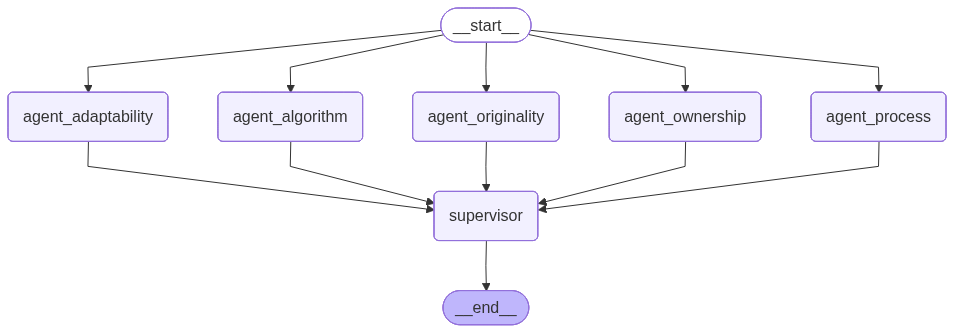

In [77]:
display(Image(app.get_graph().draw_mermaid_png()))


In [63]:
inputs = {
    "problem_statement": "Factorial of N",
    "student_code": 
        "def fact(n): return 1 if n==0 else n*fact(n-1) ",
    "execution_logs": "Ran once, passed tests."
}

result = app.invoke(inputs)
display(Markdown(result['final_report']))

[3] Adaptability Analysis...
[1] Algo Analysis...
[4] Checking Originality...
[2] Ownership Probing...
[5] Analyzing Session Logs...


C:\Users\nagav\AppData\Local\Temp\ipykernel_26996\3596834423.py:8: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return {"agent1_algo": res.dict()}
C:\Users\nagav\AppData\Local\Temp\ipykernel_26996\3596834423.py:40: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return {"agent5_process": res.dict()}
C:\Users\nagav\AppData\Local\Temp\ipykernel_26996\3596834423.py:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return {"agent4_originality": res.dict()}
C:\Users\nagav\AppData\Local

[S] Aggregating Structured Results...



    ### ASSESSMENT SCORE: 44/50
    - **Complexity**: O(N)
    - **AI Prob**: 1/15
    - **Break Scenario**: The code does not handle negative integers, which will lead to a recursion error or infinite recursion.
    

In [65]:
print(result['final_report'])


    ### ASSESSMENT SCORE: 44/50
    - **Complexity**: O(N)
    - **AI Prob**: 1/15
    - **Break Scenario**: The code does not handle negative integers, which will lead to a recursion error or infinite recursion.
    


In [69]:
bad_inputs = {
    "problem_statement": "Sort 100,000 integers efficiently.",
    "student_code": """
def sort_stuff(arr):
    # Bubble sort is best sort
    n = len(arr)
    for i in range(n):
        for j in range(0, n-i-1):
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr
""",
    "execution_logs": "Downloaded from code-snippets.com. Ran once. Zero errors."
}
result = app.invoke(bad_inputs)
display(Markdown(result['final_report']))

[3] Adaptability Analysis...
[1] Algo Analysis...
[4] Checking Originality...
[2] Ownership Probing...
[5] Analyzing Session Logs...


C:\Users\nagav\AppData\Local\Temp\ipykernel_26996\1196441748.py:40: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return {"agent5_process": res.dict()}
C:\Users\nagav\AppData\Local\Temp\ipykernel_26996\1196441748.py:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return {"agent4_originality": res.dict()}
C:\Users\nagav\AppData\Local\Temp\ipykernel_26996\1196441748.py:24: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return {"agent3_adaptability": res.dict()}


[S] Aggregating Structured Results...



    ### ASSESSMENT SCORE: 29/50
    - **Complexity**: O(N^2)
    - **AI Prob**: 3/15
    - **Break Scenario**: The input array 'arr' contains 100,000 integers, which makes bubble sort inefficient due to its O(n^2) time complexity.
    

In [78]:
confusing_inputs = {
    "problem_statement": "Calculate the Factorial of N.",
    "student_code": """
def solution(n):
    # Just a simple recursive approach
    return (lambda f: (lambda x: x(x))(lambda x: f(lambda *args: x(x)(*args))))(
        lambda rec: lambda n: 1 if n <= 1 else n * rec(n - 1)
    )(n)
""",
    "execution_logs": "Passed all hidden test cases. Local execution: 120 for n=5."
}

result = app.invoke(confusing_inputs)
display(Markdown(result['final_report']))

[3] Adaptability Analysis...
[1] Algo Analysis...
[4] Checking Originality...
[2] Ownership Probing...
[5] Analyzing Session Logs...
[S] Aggregating Structured Results...



    ### ASSESSMENT SCORE: 32/50
    - **Complexity**: O(N)
    - **Originality Verdict**: 2/15
    - **Reasoning**: The code uses a Y-combinator for a simple recursive factorial calculation, which is an example of over-engineering. This pattern is not commonly used by students, who would typically implement recursion in a straightforward manner. The use of lambda functions and the Y-combinator indicates a higher level of understanding that is not typical for beginner programmers. Additionally, the code is perfectly styled according to PEP8, which is unusual for obscure or less experienced code.
    - **Break Scenario**: The input value of N is changed to a negative integer, which is not valid for factorial calculation.

    **Verification Questions for Student:**
    1. Why is a lambda function used for recursion instead of a standard function definition, and what are the implications of this choice on readability and maintainability?
    2. What is the purpose of the double lambda structure (i.e., the self-referential lambda) in this code, and how does it affect the performance and stack usage compared to a traditional recursive function?
    3. How does the use of closures in this implementation impact the scope and lifetime of variables, and what potential issues could arise from this approach in a larger codebase?
    